In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# built-in statistics function for unbiased variance
from statistics import variance

# time series analysis
from statsmodels.tsa import stattools

#plotting
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 20})

Phoenix: 3002

Tuscon: 1011

Portland: 80

San Diego: 1007

Pittsburg: 3001 (best)

In [2]:
# importing data
cols = [3, 5, 8, 13, 18]
ds = pd.read_csv('./pollution_us_2000_2016.csv', header=0, usecols=cols)

ds

,Site Num,State,Date Local,NO2 AQI,O3 AQI
0,3002,Arizona,2000-01-01,46,34
1,3002,Arizona,2000-01-01,46,34
2,3002,Arizona,2000-01-01,46,34
3,3002,Arizona,2000-01-01,46,34
4,3002,Arizona,2000-01-02,34,27
...,...,...,...,...,...
1746656,100,Wyoming,2016-03-30,1,44
1746657,100,Wyoming,2016-03-31,1,44
1746658,100,Wyoming,2016-03-31,1,44
1746659,100,Wyoming,2016-03-31,1,44


In [3]:
# cleaning data

# selecting station in Pittsburg, Pennsylvania
pitts = ds[(ds['Site Num'] == 3001)]

# removing station no., state columns
pitts = pitts.drop(['Site Num', 'State'], axis=1)

# Delete rows with NaNs
pitts = pitts.dropna(axis='rows')

# Change date from string to date value
pitts['Date Local'] = pd.to_datetime(pitts['Date Local'], format='%Y-%m-%d')

pitts

,Date Local,NO2 AQI,O3 AQI
7848,2000-01-01,25,16
7849,2000-01-01,25,16
7850,2000-01-01,25,16
7851,2000-01-01,25,16
7852,2000-01-02,16,19
...,...,...,...
1735754,2016-03-30,35,48
1735755,2016-03-31,11,45
1735756,2016-03-31,11,45
1735757,2016-03-31,11,45


In [4]:
# count NaNs in AQI index cols (sanity check)
print('NO2: ', pitts['NO2 AQI'].isna().sum())
print('O3: ', pitts['O3 AQI'].isna().sum())

NO2:  0
O3:  0


In [5]:
months = np.arange(1,13)
years = np.arange(2000,2016)
nmonths = int(16*12)

NO2means = np.zeros(nmonths)
O3means = np.zeros(nmonths)

j = 0
for YY in years:
    for MM in months:
        NO2means[j] = pitts['NO2 AQI'][(pitts['Date Local'].dt.month==MM)
                                         & (pitts['Date Local'].dt.year==YY)].mean()
        O3means[j] = pitts['O3 AQI'][(pitts['Date Local'].dt.month==MM)
                                         & (pitts['Date Local'].dt.year==YY)].mean()
        
        j += 1

In [6]:
t = ['01/2000', '01/2001', '01/2002', '01/2003', '01/2004', '01/2005', '01/2006', '01/2007', '01/2008',
     '01/2009', '01/2010', '01/2011', '01/2012', '01/2013', '01/2014', '01/2015', '01/2016']

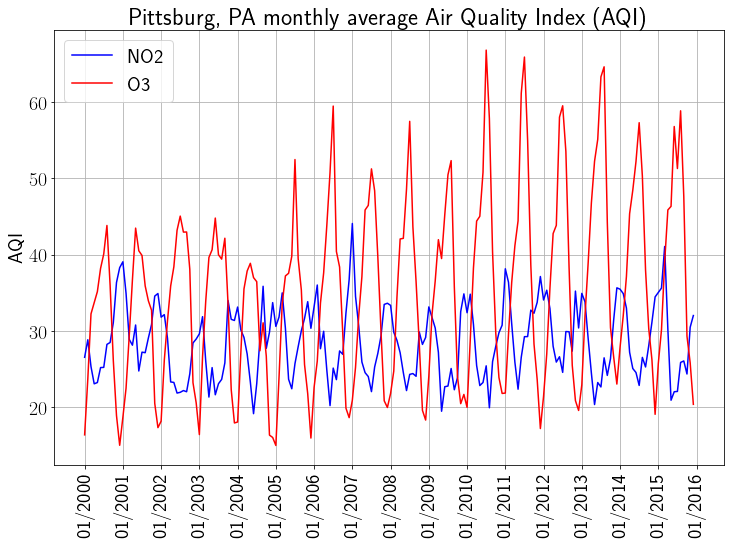

In [7]:
# plotting
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(range(nmonths), NO2means, 'b', label='NO2')
ax.plot(range(nmonths), O3means, 'r', label='O3')
ax.set_ylabel('AQI')
ax.legend(loc='upper left')
ax.set_xticks(np.arange(0,nmonths+12,12))
ax.set_xticklabels(t,rotation='vertical')
ax.set_title('Pittsburg, PA monthly average Air Quality Index (AQI)')
ax.grid()

**Ideas**
1. Fit gamma distribution to summer and winter months
2. Covariance and correlation of time series
3. Propose autoregressive model
4. Bayesian inference for parameters
5. Credible interval
6. Hypothesis test (chi-squared against proposed Gamma distribution)

Series = sinusoidal deterministic part + noise?

Model noise first

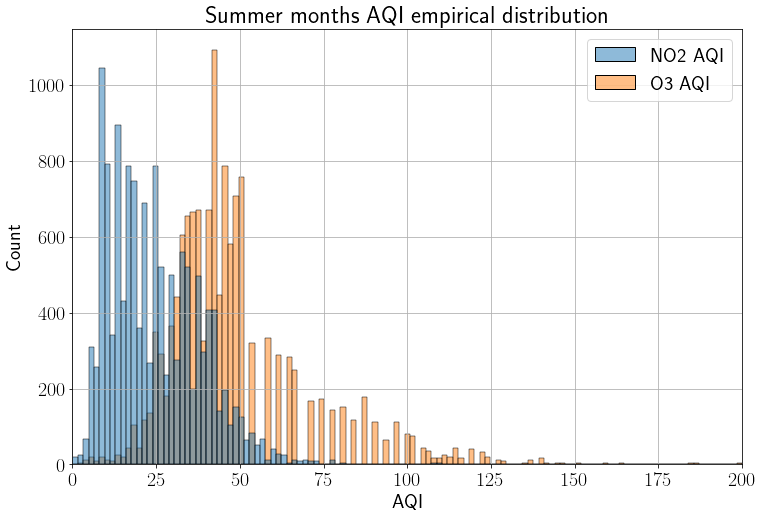

In [8]:
summer = pitts[(pitts['Date Local'].dt.month>5)&(pitts['Date Local'].dt.month<9)]

plt.figure(figsize=(12,8))
sns.histplot(summer)
plt.xlim([0,200])
plt.xlabel('AQI')
plt.title('Summer months AQI empirical distribution')
plt.grid()

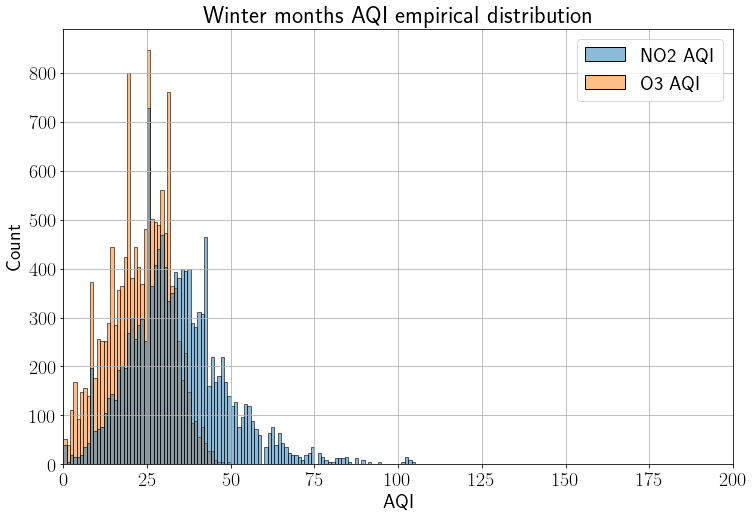

In [9]:
winter = pitts[(pitts['Date Local'].dt.month>11)|(pitts['Date Local'].dt.month<3)]

plt.figure(figsize=(12,8))
sns.histplot(winter)
plt.xlim([0,200])
plt.xlabel('AQI')
plt.title('Winter months AQI empirical distribution')
plt.grid()

Autocovariance

In [10]:
autocovNO2 = stattools.acovf(NO2means)
autocovO3 = stattools.acovf(O3means)

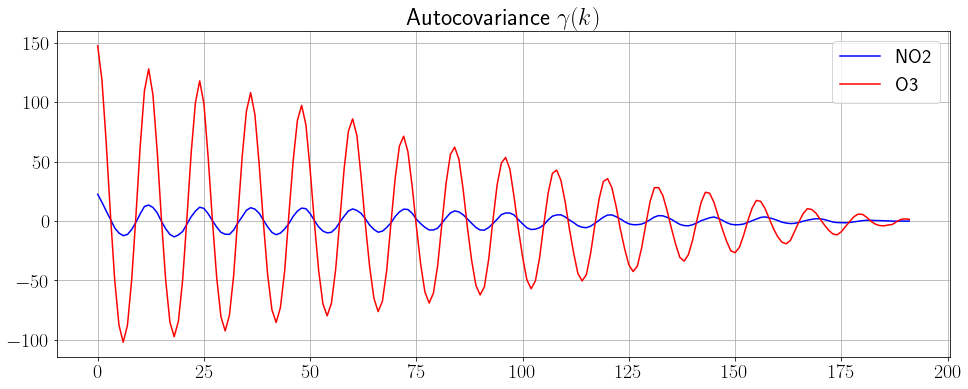

In [11]:
fig = plt.figure(figsize=(16,6))
plt.plot(range(nmonths), autocovNO2, 'b', label='NO2')
plt.plot(range(nmonths), autocovO3, 'r', label='O3')
plt.legend(loc=0)
plt.title('Autocovariance $\gamma (k)$')
plt.grid()